# Activity recognition on the Capture24 dataset

## Long short-term memory

*This section assumes familiarity with [PyTorch](https://pytorch.org/)*

We have seen the importance of accounting for the temporal dependencies in
the data to improve the classification accuracy. We have done so by using a
Hidden Markov Model to smooth the predictions of a random forest. Here we
look at using a more flexible model &mdash; the Long short-term memory (LSTM) &mdash;
to model the temporal dependencies to smooth the predictions of the random
forest.

###### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
# from tqdm import tqdm
from tqdm.notebook import tqdm
import utils

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)
cudnn.benchmark = True

# Function to plot dict of scores
def plot_scores(scores, xlabel=None, ylabel=None):
    fig, ax = plt.subplots()
    for key, vals in scores.items():
        ax.plot(vals, label=key)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    return fig, ax

 ###### Load dataset and hold out some instances for testing 

In [2]:
# data = np.load('capture24.npz', allow_pickle=True)
data = np.load('capture24_small.npz', allow_pickle=True)
print("Contents of capture24.npz:", data.files)
X, y, pid, time = data['X_feats'], data['y'], data['pid'], data['time']

# Hold out some participants for testing the model
pids_test = [2, 3]  # participants 2 & 3
mask_test = np.isin(pid, pids_test)
mask_train = ~mask_test
X_train, y_train, pid_train, time_train = \
    X[mask_train], y[mask_train], pid[mask_train], time[mask_train]
X_test, y_test, pid_test, time_test = \
    X[mask_test], y[mask_test], pid[mask_test], time[mask_test]
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Contents of capture24.npz: ['X_feats', 'y', 'pid', 'time', 'annotation']
Shape of X_train: (6025, 125)
Shape of X_test: (4991, 125)


 ###### Grab a GPU if there is one 

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.set_device(1)
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))

Using cpu


 ###### Train random forest classifier 

In [4]:
random_forest = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=2)
random_forest.fit(X_train, y_train)
# grab out-of-bag probability estimations -- this will be the input to the LSTM
Y_train = random_forest.oob_decision_function_.astype('float32')

## Smoothing the predictions with a LSTM
In the Hidden Markov Model, smoothing of the current prediction is based on
the current and past prediction of the random forest. Here we use a LSTM
to smooth the current prediction based on the current and past *two*
predictions of the random forest.

###### Architecture design
As a baseline, we use a simple one-cell LSTM.
The input to the network is a `(3,N,5)` array corresponding to `N` sequences
of length 3 of (current and past two) random forest outputs. The network
output is a `(N,5)` array representing the predicted *class scores* for each
of the `N` sequences. To obtain probabilities, we can pass each row to a
softmax. Then to report a class label, we can pick the highest probability in
each row. We output class scores instead of class probabilities or labels
because the loss function that we will use operates on the scores (see
further below).

In [5]:
class LSTM(nn.Module):

    def __init__(self, input_size=5, output_size=5, hidden_size=8):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.hidden2output = nn.Linear(hidden_size, output_size)

    def forward(self, sequence):
        _, (hidden_last, cell_last) = self.lstm(
            sequence.view(len(sequence), -1, self.input_size))
        output = self.hidden2output(hidden_last.view(-1, self.hidden_size))
        return output

###### Helper functions

We need a few helper functions:
- A data loader that will provide the mini-batches during training.
- A helper function that forward-passes the model on a dataset by chunks
&mdash; this is simply to prevent the memory from blowing up.
- A function that evaluates the model (RF + LSTM) on a dataset, to be used to
track the performance during training.

In [6]:
def create_dataloader(Y, y=None, num_prev=2, batch_size=1, shuffle=False):
    ''' Create a (batch) iterator over the dataset. It yields (batches of)
    sequences of num_prev+1 consecutive rows of Y, paired with the
    corresponding rows of y. This iterator can also be implemented with
    PyTorch's Dataset and DataLoader classes -- See
    https://pytorch.org/tutorials/beginner/data_loading_tutorial.html '''
    if shuffle:
        idxs = np.random.permutation(np.arange(num_prev, len(Y)))
    else:
        idxs = np.arange(num_prev, len(Y))
    for i in range(0, len(idxs), batch_size):
        idxs_batch = idxs[i:i+batch_size]
        # batch of sequences of num_prev+1 consecutive instances
        sequence_batch = np.stack([Y[j-num_prev:j+1]for j in idxs_batch], axis=1)
        sequence_batch = torch.from_numpy(sequence_batch)
        if y is None:
            yield sequence_batch
        else:
            y_batch = torch.from_numpy(y[idxs_batch])
            yield sequence_batch, y_batch

def forward_by_batches(lstm, Y_in, num_prev):
    ''' Forward pass model on a dataset. Do this by batches so that we do
    not blow up the memory. '''
    Y_out = []
    lstm.eval()
    with torch.no_grad():
        for sequence in create_dataloader(Y_in, num_prev=num_prev, batch_size=1024, shuffle=False):  # do not shuffle here!
            sequence = sequence.to(device)
            Y_out.append(lstm(sequence))
    lstm.train()
    Y_out = torch.cat(Y_out)
    return Y_out

def evaluate_model(random_forest, lstm, num_prev, X, y, pid=None):
    Y_pred = random_forest.predict_proba(X).astype('float32')  # rf predictions
    Y_pred = forward_by_batches(lstm, Y_pred, num_prev)  # lstm smoothing (scores)
    Y_pred = F.softmax(Y_pred, dim=1)  # convert to probabilities
    y_lstm = torch.argmax(Y_pred, dim=1)  # convert to classes
    y_lstm = y_lstm.cpu().numpy()  # cast to numpy array
    # First num_prev predictions are taken directly from the random forest classifier
    y_lstm = np.concatenate((random_forest.predict(X[:num_prev]), y_lstm))
    kappa = utils.cohen_kappa_score(y, y_lstm, pid)
    accuracy = utils.accuracy_score(y, y_lstm, pid)
    return kappa, accuracy

###### Hyperparameters, model instantiation, loss function and optimizer

Now we set the hyperparameters, instantiate the model, define the loss
function (we use cross entropy for multiclass classification) and optimizer
(we use AMSGRAD &mdash; a variant of SGD).

In [7]:
hidden_size = 8  # size of LSTM's hidden state
input_size = output_size = utils.NUM_CLASSES  # number of classes (sleep, sedentary, etc...)
num_prev = 2  # num of past predictions to look at -- num_prev+1 equals the sequence length
num_epoch = 50  # num of epochs (full loops though the training set) for SGD training
lr = 1e-3  # learning rate in SGD
batch_size = 32  # size of the mini-batch in SGD

lstm = LSTM(
    input_size=input_size,
    output_size=output_size,
    hidden_size=hidden_size
).to(device)
print(lstm)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm.parameters(), lr=lr, amsgrad=True)

LSTM(
  (lstm): LSTM(5, 8)
  (hidden2output): Linear(in_features=8, out_features=5, bias=True)
)


###### Training

Training via mini-batch gradient descent begins here. We loop through the
training set `num_epoch` times with the `dataloader` iterator.

In [8]:
losses = []
kappa_history = {'train':[], 'test':[]}
accuracy_history = {'train':[], 'test':[]}
for i in tqdm(range(num_epoch)):
    dataloader = create_dataloader(Y_train, y_train, num_prev, batch_size, shuffle=True)
    for sequence, target in dataloader:
        sequence, target = sequence.to(device), target.to(device)
        lstm.zero_grad()
        output = lstm(sequence)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        # Logging -- cross entropy loss
        losses.append(loss.item())

    # -------------------------------------------------------------------------
    # Evalutate performance at the end of each epoch (full loop through the
    # training set). We could also do this at every iteration, but this would
    # be very expensive since we are evaluating on the entire dataset.
    # -------------------------------------------------------------------------

    # Logging -- performance on train set
    kappa, accuracy = evaluate_model(
        random_forest, lstm, num_prev, X_train, y_train, pid_train)
    kappa_history['train'].append(kappa)
    accuracy_history['train'].append(accuracy)
    # Logging -- performance on test set
    kappa, accuracy = evaluate_model(
        random_forest, lstm, num_prev, X_test, y_test, pid_test)
    kappa_history['test'].append(kappa)
    accuracy_history['test'].append(accuracy)

 ###### Plot score and loss history 

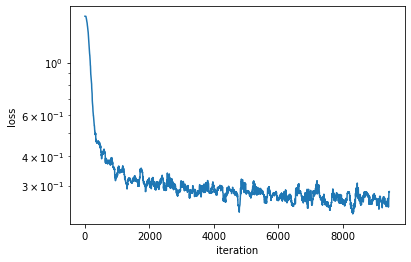

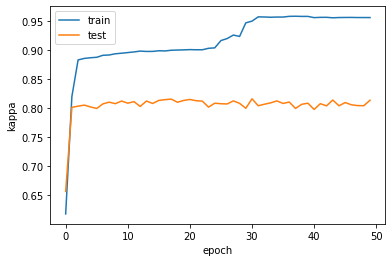

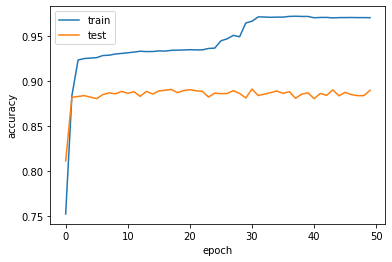

In [9]:
# Loss history
fig, ax = plt.subplots()
ax.semilogy(median_filter(losses, size=100))  # smooth for visualization
ax.set_ylabel('loss')
ax.set_xlabel('iteration')
fig.show()
# fig.savefig('lstm_loss.png')

# Score history
fig, _ = plot_scores(kappa_history, xlabel='epoch', ylabel='kappa')
fig.show()
# fig.savefig('lstm_cohen_scores.png')
fig, _ = plot_scores(accuracy_history, xlabel='epoch', ylabel='accuracy')
fig.show()
# fig.savefig('lstm_accuracy_scores.png')

###### Ideas
- Implement an early stopping mechanism to select the model at its best out-of-sample performance. Do we track kappa or accuracy?
- Tune size and number of layers of the LSTM. See [module doc](https://pytorch.org/docs/stable/nn.html#lstm).
- Instead of looking at past predictions, try looking at past and future predictions.

###### References
- [Sequence models and LSTM in PyTorch](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)
- [A recipe for training neural networks](http://karpathy.github.io/2019/04/25/recipe/)